# L1 and L2 Regularization From Scratch

Implementing Ridge (L2) and Lasso (L1) regression from scratch:
1. Ridge Regression (L2 penalty)
2. Lasso Regression (L1 penalty)
3. Comparison with standard linear regression
4. Effect on coefficients

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)


---
## Generate Data with Noise

Create dataset with many features, some irrelevant.

In [2]:
# Generate data
n_samples = 100
n_features = 20

# True coefficients (sparse - many zeros)
true_coef = np.zeros(n_features)
true_coef[0] = 5.0
true_coef[2] = 3.0
true_coef[5] = -2.0
true_coef[10] = 1.5

X = np.random.randn(n_samples, n_features)
y = X.dot(true_coef) + np.random.randn(n_samples) * 0.5

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Dataset: {n_samples} samples, {n_features} features')
print(f'True non-zero coefficients: {np.sum(true_coef != 0)}')
print(f'True coefficients:\n{true_coef}')


Dataset: 100 samples, 20 features
True non-zero coefficients: 4
True coefficients:
[ 5.   0.   3.   0.   0.  -2.   0.   0.   0.   0.   1.5  0.   0.   0.
  0.   0.   0.   0.   0.   0. ]


---
## Implementation 1: Ridge Regression (L2)

Cost: $J(\theta) = \frac{1}{2m}||X\theta - y||^2 + \frac{\lambda}{2m}||\theta||^2$

Closed form solution: $\theta = (X^TX + \lambda I)^{-1}X^Ty$

In [3]:
def ridge_regression(X, y, lambda_reg):
    """
    Ridge regression using normal equation.
    
    Cost: J = (1/2m)||Xθ - y||^2 + (λ/2m)||θ||^2
    Solution: θ = (X^T X + λI)^(-1) X^T y
    """
    m, n = X.shape
    identity = np.eye(n)
    
    # Normal equation with L2 penalty
    theta = np.linalg.inv(X.T.dot(X) + lambda_reg * identity).dot(X.T).dot(y)
    return theta

# Test different lambda values
lambdas = [0, 0.1, 1.0, 10.0, 100.0]
ridge_coefs = []

for lam in lambdas:
    coef = ridge_regression(X_scaled, y, lam)
    ridge_coefs.append(coef)
    print(f'λ = {lam:6.1f}: ||θ||^2 = {np.sum(coef**2):.4f}, non-zeros = {np.sum(np.abs(coef) > 0.01)}')

ridge_coefs = np.array(ridge_coefs)


λ =    0.0: ||θ||^2 = 36.5543, non-zeros = 17
λ =    0.1: ||θ||^2 = 36.4693, non-zeros = 17
λ =    1.0: ||θ||^2 = 35.7205, non-zeros = 17
λ =   10.0: ||θ||^2 = 29.5069, non-zeros = 20
λ =  100.0: ||θ||^2 = 8.9690, non-zeros = 19


### Visualize Ridge Coefficients

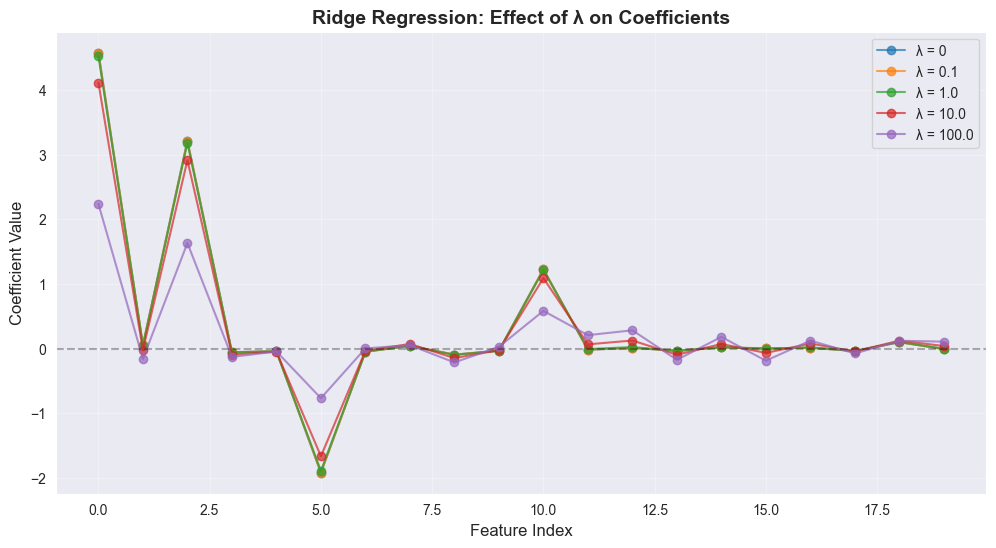

In [4]:
plt.figure(figsize=(12, 6))
for i, lam in enumerate(lambdas):
    plt.plot(ridge_coefs[i], marker='o', label=f'λ = {lam}', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.title('Ridge Regression: Effect of λ on Coefficients', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Observation**: As λ increases, all coefficients shrink toward zero, but none become exactly zero.

---
## Implementation 2: Lasso Regression (L1)

Cost: $J(\theta) = \frac{1}{2m}||X\theta - y||^2 + \frac{\lambda}{m}||\theta||_1$

No closed form - use coordinate descent.

In [5]:
def soft_threshold(x, lambda_val):
    """Soft thresholding operator for Lasso."""
    if x > lambda_val:
        return x - lambda_val
    elif x < -lambda_val:
        return x + lambda_val
    else:
        return 0.0

def lasso_regression(X, y, lambda_reg, max_iter=1000, tol=1e-4):
    """
    Lasso regression using coordinate descent.
    """
    m, n = X.shape
    theta = np.zeros(n)
    
    for iteration in range(max_iter):
        theta_old = theta.copy()
        
        for j in range(n):
            # Compute residual without feature j
            residual = y - X.dot(theta) + X[:, j] * theta[j]
            
            # Compute correlation
            rho = X[:, j].dot(residual)
            
            # Update with soft thresholding
            theta[j] = soft_threshold(rho, lambda_reg * m) / (X[:, j].dot(X[:, j]))
        
        # Check convergence
        if np.sum(np.abs(theta - theta_old)) < tol:
            break
    
    return theta

# Test different lambda values
lasso_coefs = []

for lam in lambdas:
    coef = lasso_regression(X_scaled, y, lam)
    lasso_coefs.append(coef)
    print(f'λ = {lam:6.1f}: ||θ||_1 = {np.sum(np.abs(coef)):.4f}, non-zeros = {np.sum(np.abs(coef) > 0.01)}')

lasso_coefs = np.array(lasso_coefs)


λ =    0.0: ||θ||_1 = 11.5514, non-zeros = 17
λ =    0.1: ||θ||_1 = 10.5849, non-zeros = 4
λ =    1.0: ||θ||_1 = 6.8398, non-zeros = 4
λ =   10.0: ||θ||_1 = 0.0000, non-zeros = 0
λ =  100.0: ||θ||_1 = 0.0000, non-zeros = 0


### Visualize Lasso Coefficients

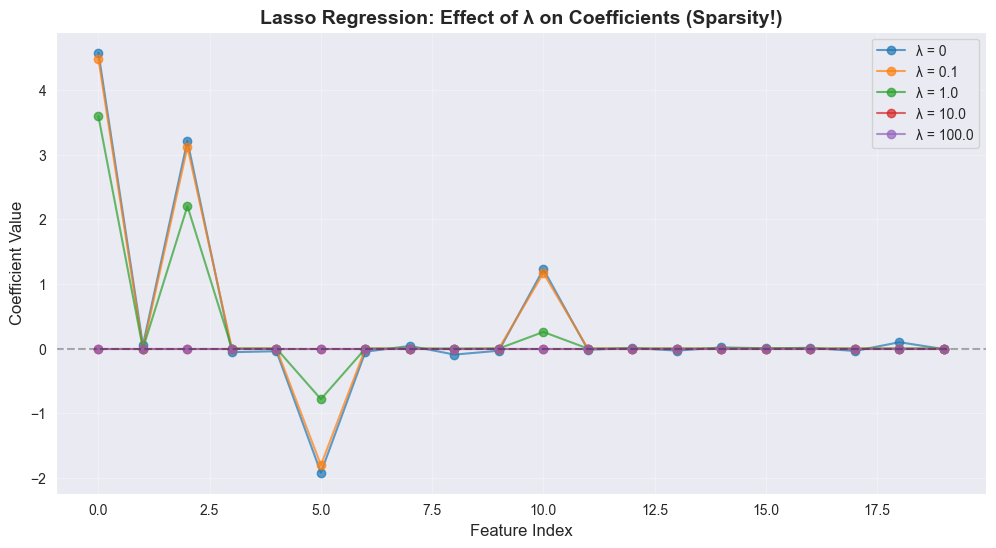

In [6]:
plt.figure(figsize=(12, 6))
for i, lam in enumerate(lambdas):
    plt.plot(lasso_coefs[i], marker='o', label=f'λ = {lam}', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.title('Lasso Regression: Effect of λ on Coefficients (Sparsity!)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Observation**: As λ increases, many coefficients become exactly zero (sparse solution).

---
## Comparison: Ridge vs Lasso

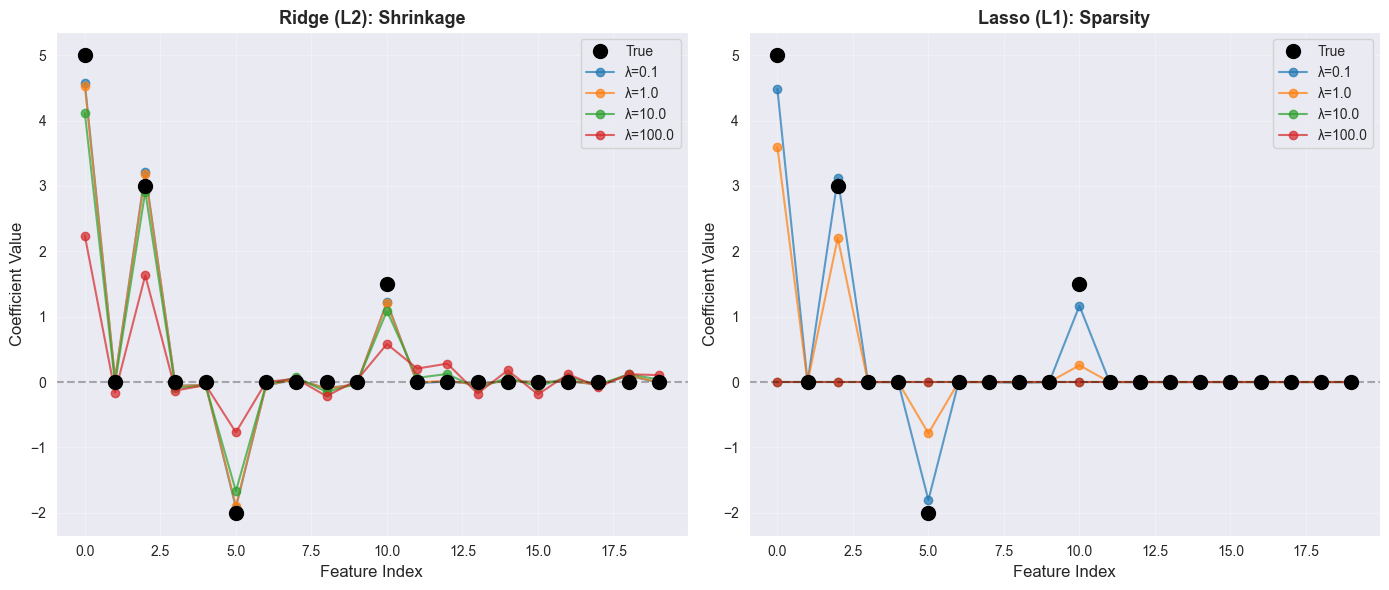

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ridge path
axes[0].plot(true_coef, 'ko', markersize=10, label='True', zorder=10)
for i, lam in enumerate(lambdas[1:]):
    axes[0].plot(ridge_coefs[i+1], marker='o', label=f'λ={lam}', alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Feature Index', fontsize=12)
axes[0].set_ylabel('Coefficient Value', fontsize=12)
axes[0].set_title('Ridge (L2): Shrinkage', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Lasso path
axes[1].plot(true_coef, 'ko', markersize=10, label='True', zorder=10)
for i, lam in enumerate(lambdas[1:]):
    axes[1].plot(lasso_coefs[i+1], marker='o', label=f'λ={lam}', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Feature Index', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('Lasso (L1): Sparsity', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---
## Compare with Scikit-Learn

In [8]:
# Our Ridge
our_ridge = ridge_regression(X_scaled, y, lambda_reg=1.0)

# sklearn Ridge
sklearn_ridge = Ridge(alpha=1.0, fit_intercept=False)
sklearn_ridge.fit(X_scaled, y)

print('Ridge Comparison (λ=1.0):')
print(f'Our implementation:   {our_ridge[:5]} ...')
print(f'sklearn:              {sklearn_ridge.coef_[:5]} ...')
print(f'Max difference:       {np.max(np.abs(our_ridge - sklearn_ridge.coef_)):.6f}')

print('\nLasso Comparison (λ=1.0):')
our_lasso = lasso_regression(X_scaled, y, lambda_reg=1.0)
sklearn_lasso = Lasso(alpha=1.0, fit_intercept=False)
sklearn_lasso.fit(X_scaled, y)

print(f'Our implementation:   {our_lasso[:5]} ...')
print(f'sklearn:              {sklearn_lasso.coef_[:5]} ...')
print(f'Max difference:       {np.max(np.abs(our_lasso - sklearn_lasso.coef_)):.6f}')


Ridge Comparison (λ=1.0):
Our implementation:   [ 4.5276873   0.04398072  3.18247123 -0.06156558 -0.04316916] ...
sklearn:              [ 4.5276873   0.04398072  3.18247123 -0.06156558 -0.04316916] ...
Max difference:       0.000000

Lasso Comparison (λ=1.0):
Our implementation:   [3.59487505 0.         2.20453486 0.         0.        ] ...
sklearn:              [ 3.5948804  -0.          2.20453454 -0.         -0.        ] ...
Max difference:       0.000005


---
## Summary

### Ridge Regression (L2):
- Adds $\frac{\lambda}{2m}\sum\theta_j^2$ to cost
- Shrinks all coefficients toward zero
- Never produces exact zeros
- Has closed-form solution
- Handles multicollinearity well

### Lasso Regression (L1):
- Adds $\frac{\lambda}{m}\sum|\theta_j|$ to cost
- Forces some coefficients to exactly zero
- Automatic feature selection
- Requires iterative solution (coordinate descent)
- Creates sparse models

### When to Use:
- **Ridge**: All features are potentially useful, want to reduce overfitting
- **Lasso**: Suspect many features are irrelevant, want automatic selection
- **Elastic Net**: Want benefits of both (compromise)

**Interview Tip**: "Ridge shrinks coefficients smoothly, Lasso forces some to zero for feature selection. I'd use cross-validation to choose between them based on which gives better validation performance."